For this task, I will use the CIFAR-10 dataset, which consists of 10 classes of coloured images, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The dataset contains 60,000 images - 50,000 images for the training set and 10,000 images for the testing set. Each image is a 32x32 pixel RGB image (3 channels: red, green, and blue), labeled according to its class. The pixel values range from 0 to 255, representing the intensity of each color channel.

I had issues importing cifar-10 from conventional sources such as keras or PyTorch, so I used Kaggle instead and downloaded the dataset as compressed numpy arrays: https://www.kaggle.com/datasets/guesejustin/cifar10-keras-files-cifar10load-data?resource=download

Below I will load the datasetand display some of its characteristics mentioned above:

Training set shape: (50000, 32, 32, 3) images
Test set shape: (10000, 32, 32, 3) images
Image dimensions: 32x32 pixels


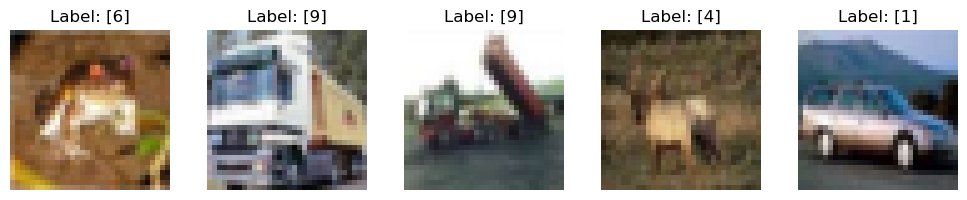

In [84]:
import numpy as np
import matplotlib.pyplot as plt

cifar_data = np.load('./cifar-10.npz')

filenames = ["x_train","y_train","x_test","y_test"]
nps = []

for filename in filenames:
    nps.append(cifar_data[filename])

x_train, y_train, x_test, y_test = nps

print(f"Training set shape: {x_train.shape} images")
print(f"Test set shape: {x_test.shape} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

# I will also display some sample images from the dataset to visualise the images I am working with

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

I will create a base convolutional neural network (using PyTorch) to classify images.
Firstly I need to normalise the images, I will use the "mean" and "std" values calulated to CIFAR-10 to normalize each RGB channel seperately:

In [85]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader, TensorDataset

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

Next I need to convert both the training and testing set to PyTorch tensors, as well as the labels, as this is what the model expects. I also apply the transformations above to x_train and y_train:

In [86]:
from PIL import Image

x_train_transformed = torch.stack([
    train_transform(Image.fromarray(img)) for img in x_train
])
x_test_transformed = torch.stack([
    test_transform(Image.fromarray(img)) for img in x_test
])

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

Now the input is prepared, I will start building the model.
I will first need to establish a baseline CNN model, which I will build on and add improvements, and then carry out hyperparameter tuning:

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Base(nn.Module):
    def __init__(self):
        super(CNN_Base, self).__init__()
        
        # 1 Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)

        # 1 Fully Connected Layer
        self.fc1 = nn.Linear(16 * 30 * 30, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
base_model = CNN_Base()

# Baseline Hyperparameters

batch_size = 64
learning_rate = 0.001
num_epochs = 8

To start with, I have defined a simple base convolutional network with 2 convolutional layers and 2 fully connected layers, and 1 pooling layer. The role of the pooling layer is to reduce the spatial dimensions of feature maps while retaining most of the important information.

In the forward pass function, the first and second convolutional layer is applied with a ReLU activation function. Then pooling is applied, and the feature maps are flattened into 1D to be fed into the fully connected layers. Then the first fully connected layer is applied with ReLU, and the second with no activation as it is handled in the loss function.

Under this, I have specified the hyperparameters that I will start off with:
- Batch size: 64 - (higher = more stable gradient updates but slower weight updates, lower = faster weight updates but gradients are noiser)
- Learning rate: 0.001 - (higher = faster training but risk of overshooting the minimum, lower = slower training but ensures more stable and precise convergence at minimum)
- Epochs: 6 - (higher = risk of overfitting, lower = risk of underfitting)

I also need to define the loss function and the optimizer for the baseline model. I will use cross-entropy loss as it is standard for multi-class classification problems, and also the adam optimizer:

In [88]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)

Before training I will also need to wrap the data in loaders now that batch size is defined:

In [89]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

I will use various metrics to measure the performance of the models:
- Loss - quantifies the model "error"
- Accuracy - proportion of correct predictions out of all
- Precision - measures the accuracy of positive predictions
- Recall - measures ability of the model to identify all positive cases
- F1 Score - combination of Precision and Recall, which is the harmonic mean of both

On the last epoch, I create a confusion matrix and format it with matplotlib and seaborn with a heatmap - like in tutorials.
Now I will train the model for the specified baseline number of epochs.

Epoch [1/8], Loss: 1.4480, Accuracy: 49.69%
Precision: 0.4927, Recall: 0.4969, F1 Score: 0.4942
Epoch [2/8], Loss: 1.1494, Accuracy: 60.19%
Precision: 0.5988, Recall: 0.6019, F1 Score: 0.6000
Epoch [3/8], Loss: 1.0259, Accuracy: 64.84%
Precision: 0.6462, Recall: 0.6484, F1 Score: 0.6471
Epoch [4/8], Loss: 0.9462, Accuracy: 67.47%
Precision: 0.6730, Recall: 0.6747, F1 Score: 0.6737
Epoch [5/8], Loss: 0.8853, Accuracy: 69.66%
Precision: 0.6950, Recall: 0.6966, F1 Score: 0.6956
Epoch [6/8], Loss: 0.8361, Accuracy: 71.26%
Precision: 0.7112, Recall: 0.7126, F1 Score: 0.7118
Epoch [7/8], Loss: 0.7881, Accuracy: 72.84%
Precision: 0.7273, Recall: 0.7284, F1 Score: 0.7277
Epoch [8/8], Loss: 0.7450, Accuracy: 74.37%
Precision: 0.7427, Recall: 0.7437, F1 Score: 0.7431


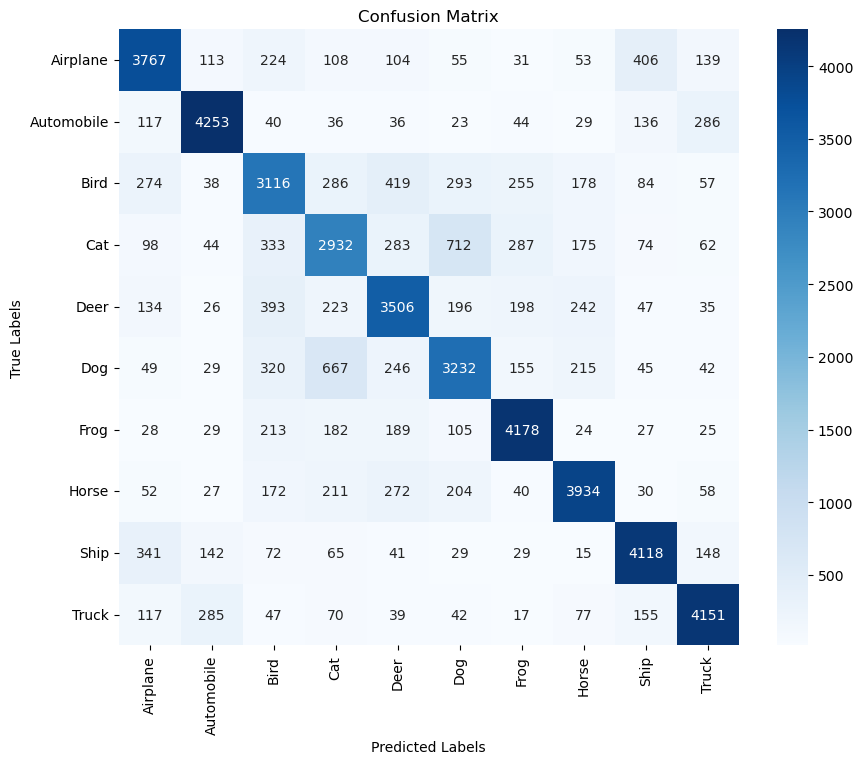

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

def train_model(model, optimizer):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        all_labels = []
        all_predictions = [] 

        for images, labels in train_loader:
            labels = labels.squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        if epoch == num_epochs - 1:
            cm = confusion_matrix(all_labels, all_predictions, labels=range(10))
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
            plt.xlabel("Predicted Labels")
            plt.ylabel("True Labels")
            plt.title("Confusion Matrix")
            plt.show()

train_model(base_model, base_optimizer)


As seen above, the model converges to 67.46% accuracy from the baseline model with a loss of 0.926. Precision and Recall are also low with 0.674, which leads to a low F1 score aswell.
The confusion matrix backs this up by showing true and false predictions for each class.

This creates a great starting point to build on.
I first want to experiment with adding 1 max pooling layer after the convolutional layer. This max pooling layer reduces the spatial dimensions of feature maps while retaining the most important information:

Epoch [1/8], Loss: 1.4352, Accuracy: 50.03%
Precision: 0.4956, Recall: 0.5003, F1 Score: 0.4970
Epoch [2/8], Loss: 1.1560, Accuracy: 60.09%
Precision: 0.5981, Recall: 0.6009, F1 Score: 0.5991
Epoch [3/8], Loss: 1.0656, Accuracy: 63.17%
Precision: 0.6292, Recall: 0.6317, F1 Score: 0.6302
Epoch [4/8], Loss: 1.0143, Accuracy: 65.05%
Precision: 0.6484, Recall: 0.6505, F1 Score: 0.6492
Epoch [5/8], Loss: 0.9747, Accuracy: 66.55%
Precision: 0.6635, Recall: 0.6655, F1 Score: 0.6643
Epoch [6/8], Loss: 0.9424, Accuracy: 67.43%
Precision: 0.6726, Recall: 0.6743, F1 Score: 0.6733
Epoch [7/8], Loss: 0.9240, Accuracy: 68.12%
Precision: 0.6796, Recall: 0.6812, F1 Score: 0.6803
Epoch [8/8], Loss: 0.9032, Accuracy: 68.80%
Precision: 0.6864, Recall: 0.6880, F1 Score: 0.6871


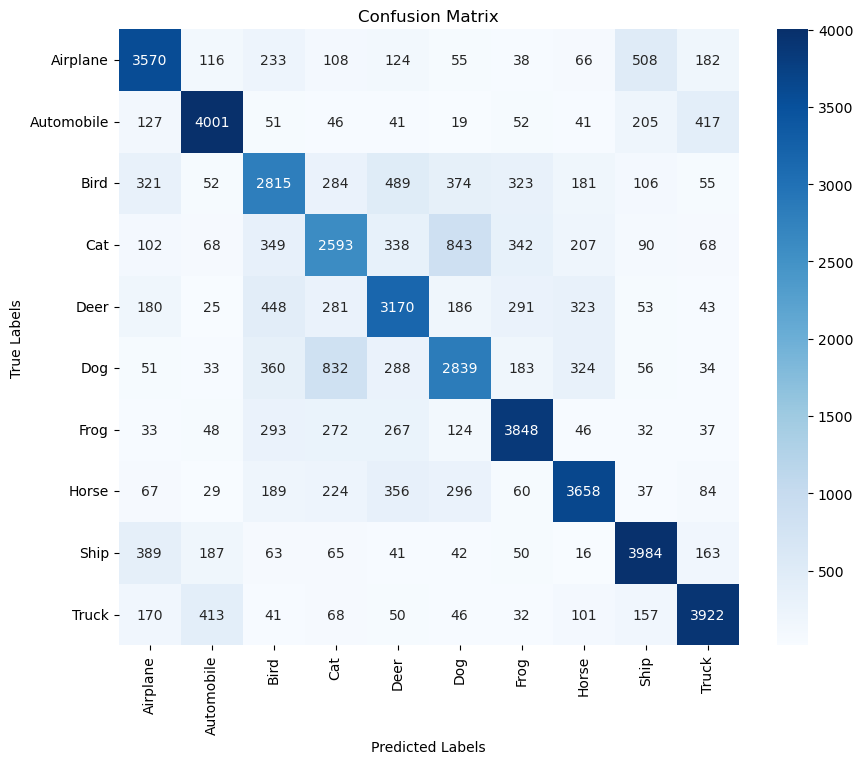

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Pool(nn.Module):
    def __init__(self):
        super(CNN_Pool, self).__init__()
        
        # 1 Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        
        # 1 Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 1 Fully Connected Layer
        self.fc1 = nn.Linear(16 * 15 * 15, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

pool_model = CNN_Pool()
pool_optimizer = optim.Adam(pool_model.parameters(), lr=learning_rate)

# Baseline Hyperparameters

batch_size = 64
learning_rate = 0.001
num_epochs = 8

train_model(pool_model, pool_optimizer)

The model with pooling shows a slight decrease in across metrics upon convergence, however it achieved its main goal of reducing memory usage and speeding up training time, as the model trained quicker.

Next, I would like to add 1 convolutional layer and 1 fully connected layer. The convolutional layer will allow the model to extract higher-level and more abstract features, whereas the extra fully connected layer will increase the model's ability to learn complex relationships between features:


Epoch [1/8], Loss: 1.3548, Accuracy: 51.26%
Precision: 0.5074, Recall: 0.5126, F1 Score: 0.5086
Epoch [2/8], Loss: 0.9671, Accuracy: 65.85%
Precision: 0.6557, Recall: 0.6585, F1 Score: 0.6569
Epoch [3/8], Loss: 0.7715, Accuracy: 73.03%
Precision: 0.7285, Recall: 0.7303, F1 Score: 0.7293
Epoch [4/8], Loss: 0.6082, Accuracy: 78.87%
Precision: 0.7877, Recall: 0.7887, F1 Score: 0.7881
Epoch [5/8], Loss: 0.4412, Accuracy: 84.98%
Precision: 0.8493, Recall: 0.8498, F1 Score: 0.8495
Epoch [6/8], Loss: 0.2967, Accuracy: 89.96%
Precision: 0.8994, Recall: 0.8996, F1 Score: 0.8995
Epoch [7/8], Loss: 0.1842, Accuracy: 93.75%
Precision: 0.9374, Recall: 0.9375, F1 Score: 0.9375
Epoch [8/8], Loss: 0.1167, Accuracy: 96.08%
Precision: 0.9607, Recall: 0.9608, F1 Score: 0.9607


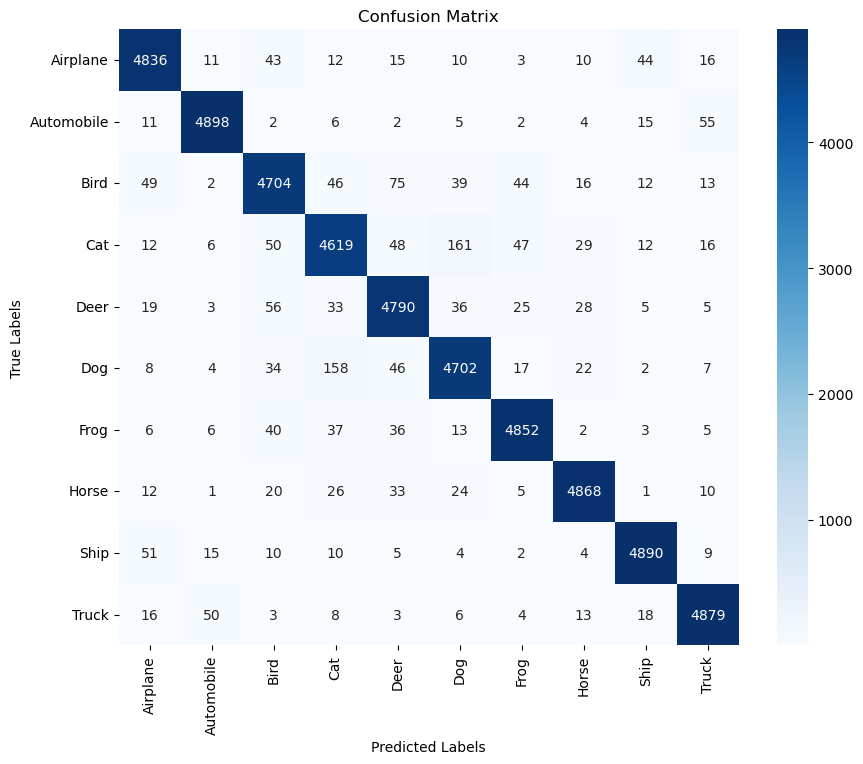

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Improved(nn.Module):
    def __init__(self):
        super(CNN_Improved, self).__init__()
        
        # 2 Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        
        # 1 Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # 2 Fully Connected Layers
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and optimizer
improved_model = CNN_Improved()
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 8

train_model(improved_model, improved_optimizer)

It is clear that the model improvements have allowed the model to converge at 96% accuracy, which is a significant improvement from the baseline model.

Now that I have added improvements to the model, I will undertake hyperparameter tuning for the improved model to determine the best settings to use.
Firstly I want to test the model with multiple learning rates, so I created an array with 4 different learning rate options, and trained the improved model for each one to see the effects:

Learning Rate: 0.1
------------------------------
Epoch [1/8], Loss: 14.7895, Accuracy: 10.03%
Precision: 0.1004, Recall: 0.1003, F1 Score: 0.0989
Epoch [2/8], Loss: 2.3115, Accuracy: 9.91%
Precision: 0.0985, Recall: 0.0991, F1 Score: 0.0968
Epoch [3/8], Loss: 2.3107, Accuracy: 9.88%
Precision: 0.0986, Recall: 0.0988, F1 Score: 0.0975
Epoch [4/8], Loss: 2.3118, Accuracy: 9.91%
Precision: 0.0989, Recall: 0.0991, F1 Score: 0.0977
Epoch [5/8], Loss: 2.3116, Accuracy: 10.06%
Precision: 0.1002, Recall: 0.1006, F1 Score: 0.0991
Epoch [6/8], Loss: 2.3119, Accuracy: 9.88%
Precision: 0.0986, Recall: 0.0988, F1 Score: 0.0976
Epoch [7/8], Loss: 2.3121, Accuracy: 9.75%
Precision: 0.0974, Recall: 0.0975, F1 Score: 0.0971
Epoch [8/8], Loss: 2.3123, Accuracy: 9.80%
Precision: 0.0978, Recall: 0.0980, F1 Score: 0.0964


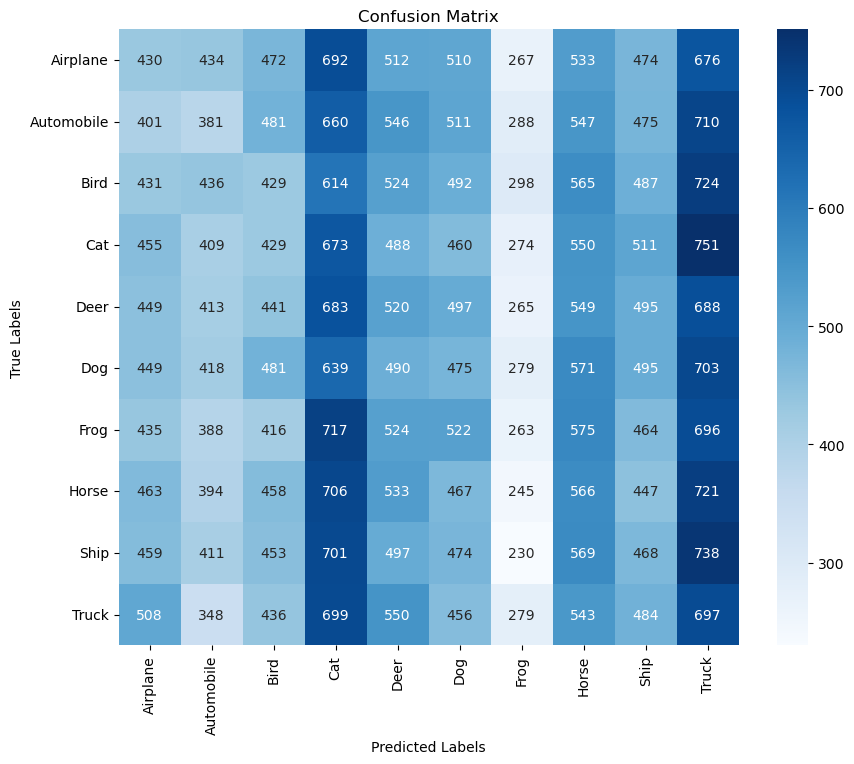

Learning Rate: 0.01
------------------------------
Epoch [1/8], Loss: 2.3322, Accuracy: 9.95%
Precision: 0.0992, Recall: 0.0995, F1 Score: 0.0911
Epoch [2/8], Loss: 2.3035, Accuracy: 10.05%
Precision: 0.1024, Recall: 0.1005, F1 Score: 0.0905
Epoch [3/8], Loss: 2.3037, Accuracy: 9.82%
Precision: 0.0968, Recall: 0.0982, F1 Score: 0.0936


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/8], Loss: 2.3036, Accuracy: 10.01%
Precision: 0.0901, Recall: 0.1001, F1 Score: 0.0898
Epoch [5/8], Loss: 2.3036, Accuracy: 10.08%
Precision: 0.0994, Recall: 0.1008, F1 Score: 0.0916
Epoch [6/8], Loss: 2.3035, Accuracy: 10.06%
Precision: 0.0980, Recall: 0.1006, F1 Score: 0.0940
Epoch [7/8], Loss: 2.3037, Accuracy: 9.69%
Precision: 0.0963, Recall: 0.0969, F1 Score: 0.0927
Epoch [8/8], Loss: 2.3037, Accuracy: 9.85%
Precision: 0.0977, Recall: 0.0985, F1 Score: 0.0919


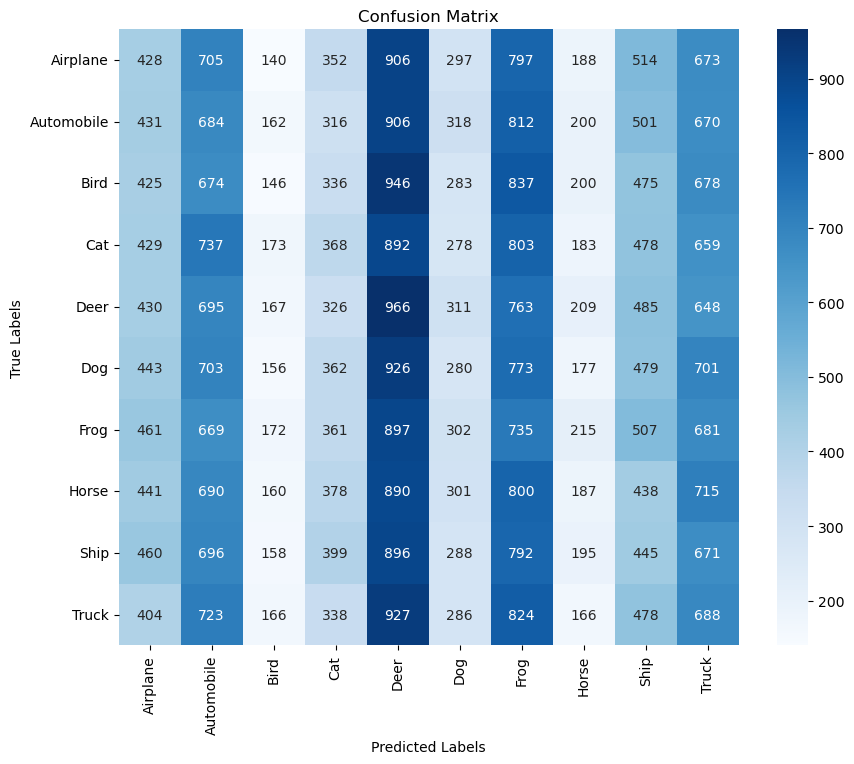

Learning Rate: 0.001
------------------------------
Epoch [1/8], Loss: 1.3049, Accuracy: 53.45%
Precision: 0.5295, Recall: 0.5345, F1 Score: 0.5309
Epoch [2/8], Loss: 0.9199, Accuracy: 67.58%
Precision: 0.6733, Recall: 0.6758, F1 Score: 0.6744
Epoch [3/8], Loss: 0.7319, Accuracy: 74.56%
Precision: 0.7439, Recall: 0.7456, F1 Score: 0.7446
Epoch [4/8], Loss: 0.5636, Accuracy: 80.39%
Precision: 0.8031, Recall: 0.8039, F1 Score: 0.8034
Epoch [5/8], Loss: 0.3914, Accuracy: 86.34%
Precision: 0.8630, Recall: 0.8634, F1 Score: 0.8632
Epoch [6/8], Loss: 0.2428, Accuracy: 91.75%
Precision: 0.9174, Recall: 0.9175, F1 Score: 0.9174
Epoch [7/8], Loss: 0.1454, Accuracy: 95.18%
Precision: 0.9518, Recall: 0.9518, F1 Score: 0.9518
Epoch [8/8], Loss: 0.0981, Accuracy: 96.72%
Precision: 0.9672, Recall: 0.9672, F1 Score: 0.9672


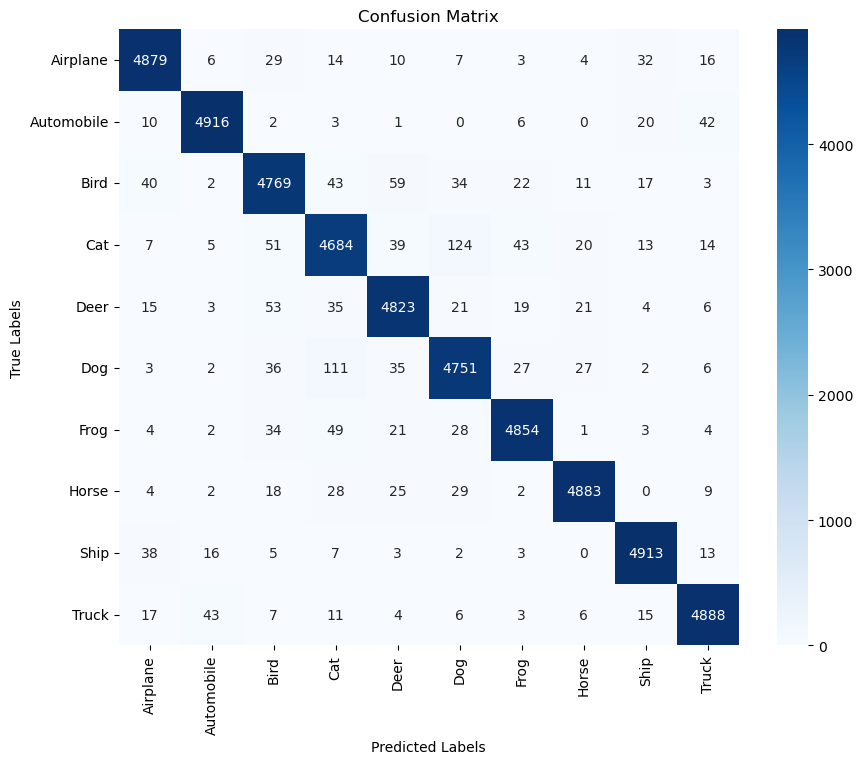

Learning Rate: 0.0001
------------------------------
Epoch [1/8], Loss: 1.6420, Accuracy: 41.86%
Precision: 0.4124, Recall: 0.4186, F1 Score: 0.4116
Epoch [2/8], Loss: 1.3331, Accuracy: 52.91%
Precision: 0.5249, Recall: 0.5291, F1 Score: 0.5261
Epoch [3/8], Loss: 1.2117, Accuracy: 57.47%
Precision: 0.5710, Recall: 0.5747, F1 Score: 0.5724
Epoch [4/8], Loss: 1.1332, Accuracy: 60.28%
Precision: 0.5995, Recall: 0.6028, F1 Score: 0.6007
Epoch [5/8], Loss: 1.0669, Accuracy: 62.68%
Precision: 0.6234, Recall: 0.6268, F1 Score: 0.6247
Epoch [6/8], Loss: 1.0107, Accuracy: 64.88%
Precision: 0.6458, Recall: 0.6488, F1 Score: 0.6469
Epoch [7/8], Loss: 0.9569, Accuracy: 66.65%
Precision: 0.6639, Recall: 0.6665, F1 Score: 0.6649
Epoch [8/8], Loss: 0.9107, Accuracy: 68.32%
Precision: 0.6807, Recall: 0.6832, F1 Score: 0.6817


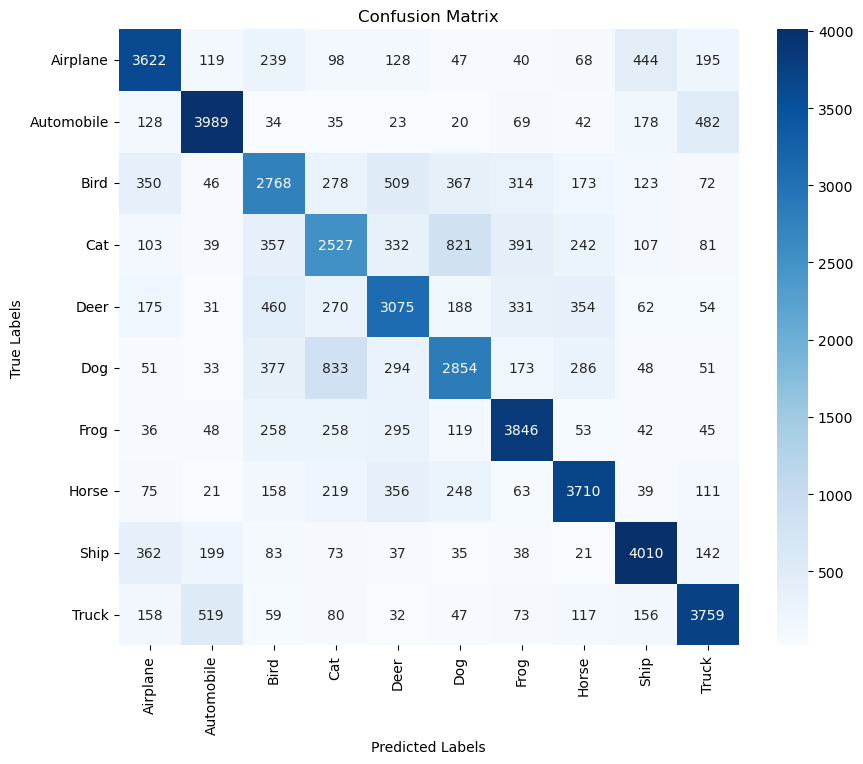

In [98]:
rates = [0.1, 0.01, 0.001, 0.0001]

for rate in rates:
    imp_model = CNN_Improved()
    imp_optimizer = torch.optim.Adam(imp_model.parameters(), lr=rate)
    print(f"Learning Rate: {rate}")
    print("-"*30)
    train_model(imp_model, imp_optimizer)

From the hyperparameter testing above, it is clear that 0.1 and 0.01 learning rates are too low for this model, preventing it from reaching the minima. 
0.001 seems perfect as the model converges at 97% accuracy and the learning process is stable, however 0.0001 is too slow and the model doesn't converge fast enough.

Next I want to 